In [1]:
import cosima_cookbook as cc
import numpy as np
from dask.distributed import Client


In [2]:
import xarray as xr
from oceanpy import Contour
import xgcm
import matplotlib.pyplot as plt

## Importing the model outputs the chosen time period and domain

In [3]:
session = cc.database.create_session()
expt01 = '01deg_jra55v140_iaf_cycle2'  # 01-deg and daily experiment 
yt_sel = slice(-60, -45)
xt_sel = slice(144.5-360, 155.5-360)
start_time, end_time = '1993-01-01', '2018-12-31'

In [4]:
client = Client(n_workers=8, memory_limit='44.9GB')
client

2023-01-09 17:36:33,004 - distributed.diskutils - INFO - Found stale lock file and directory '/local/hh5/jm6603/tmp/dask-worker-space/worker-opwfu71_', purging
2023-01-09 17:36:33,005 - distributed.diskutils - INFO - Found stale lock file and directory '/local/hh5/jm6603/tmp/dask-worker-space/worker-oehfbgn2', purging
2023-01-09 17:36:33,005 - distributed.diskutils - INFO - Found stale lock file and directory '/local/hh5/jm6603/tmp/dask-worker-space/worker-v0rtezrd', purging
2023-01-09 17:36:33,006 - distributed.diskutils - INFO - Found stale lock file and directory '/local/hh5/jm6603/tmp/dask-worker-space/worker-wiuzi2ao', purging
2023-01-09 17:36:33,007 - distributed.diskutils - INFO - Found stale lock file and directory '/local/hh5/jm6603/tmp/dask-worker-space/worker-bbpdf0nr', purging
2023-01-09 17:36:33,007 - distributed.diskutils - INFO - Found stale lock file and directory '/local/hh5/jm6603/tmp/dask-worker-space/worker-hy38wye9', purging
2023-01-09 17:36:33,008 - distributed.di

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 16,Total memory: 334.53 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46007,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 334.53 GiB
Comm: tcp://127.0.0.1:33469,Total threads: 2
Dashboard: /proxy/46679/status,Memory: 41.82 GiB
Nanny: tcp://127.0.0.1:42069,


In [5]:
var = 'u'
u = cc.querying.getvar(expt01, var, session, frequency='1 monthly', start_time=start_time, end_time=end_time)
u = u.sel(time=slice(start_time, end_time)).sel(yu_ocean=yt_sel, xu_ocean=xt_sel, st_ocean = slice(0,500))

var = 'v'
v = cc.querying.getvar(expt01, var, session, frequency='1 monthly', start_time=start_time, end_time=end_time)
v = v.sel(time=slice(start_time, end_time)).sel(yu_ocean=yt_sel, xu_ocean=xt_sel, st_ocean = slice(0,500))

In [6]:
var = 'wt'
wt = cc.querying.getvar(expt01, var, session, frequency='1 monthly', start_time=start_time, end_time=end_time)
wt = wt.sel(time=slice(start_time, end_time)).sel(yt_ocean=yt_sel, xt_ocean=xt_sel, sw_ocean = slice(0,500))

var = 'sea_level'
sl = cc.querying.getvar(expt01, var, session, frequency='1 monthly', start_time=start_time, end_time=end_time)
sl = sl.sel(time=slice(start_time, end_time)).sel(yt_ocean=yt_sel, xt_ocean=xt_sel)

In [7]:
variable = 'temp'
temp = cc.querying.getvar(expt01, variable, session, frequency = '1 monthly', start_time=start_time, end_time=end_time)
temp = temp.sel(yt_ocean=yt_sel, xt_ocean=xt_sel, st_ocean = slice(0,500),
                time=slice(start_time, end_time)) - 273.15 #the temperature of the model is in Kelvin

## We perform an 18month window average to extract the signal of the meander

In [8]:
wdw       = 18
temp_wdw  = temp.rolling(time = wdw, center = True).mean('time').compute()
u_wdw     = u.rolling(time = wdw, center = True).mean('time').compute()
v_wdw     = v.rolling(time = wdw, center = True).mean('time').compute()
w_wdw = wt.rolling(time = wdw, center = True).mean('time').compute()
sl_wdw = sl.rolling(time = wdw, center = True).mean('time').compute()

### Let's evaluate the first period of the smoothed time series (i.e., wdw/2)

In [9]:
# temp_wdw.isel(time=41).interp(st_ocean = 282).plot()
# temp_wdw.isel(time=41).interp(st_ocean = 282).plot.contour(levels=[2.9], colors='w', linestyles='solid')


In [10]:
idx = 41 # 9
temp_snap = temp_wdw.isel(time=41)
u_snap = u_wdw.isel(time=41)
v_snap = v_wdw.isel(time=41)
w_snap = w_wdw.isel(time=41)
sl_snap = sl_wdw.isel(time=41)

# temp_snap = temp_wdw[int(wdw/2)]
# u_snap = u_wdw[int(wdw/2)]
# v_snap = v_wdw[int(wdw/2)]
# sl_snap = sl_wdw[int(wdw/2)]

In [11]:
## --> That is the variable that you use to find the coordinates of the front
temp_PF   = temp_snap.interp(st_ocean = 282).compute()

## TBC

--> Things to note: the isotherm that represents the PF is the 2.9$^\circ$C at 282 m
--> The model outputs are in T-cell coordinates (i.e., to convert the longitudes to the cartesin grid, you need to sum 360$^\circ$) ----> Ln, Lt = temp.xt_ocean + 360, temp.yt_ocean

In [12]:
ds = xr.merge([temp_PF, u_snap, v_snap, w_snap, sl_snap])

In [13]:
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5,periodic=False)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
ds.coords['st_ocean'].attrs.update(axis='Z')
# ds.coords['sw_ocean'].attrs.update(axis='Z', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=False, boundary='extend')#, periodic=['X']
grid

<xgcm.Grid>
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
Z Axis (not periodic, boundary='extend'):
  * center   st_ocean
X Axis (not periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center

In [14]:
u_grd = grid.interp(grid.interp(ds.u, 'X'), 'Y')
v_grd = grid.interp(grid.interp(ds.v, 'X'), 'Y')
u_grd.name, v_grd.name = 'u', 'v'
ds['u'], ds['v'] = u_grd, v_grd

In [15]:
temp_contour = 2.9
sl_contour = -.9

# along contour section (2.9 temperature contour)
cont_temp = Contour(ds, coords=('xt_ocean', 'yt_ocean'))
cont_temp.get_coords(contour_name='temp', contour_value=temp_contour, interp=True, spacing=20000)
along_section_temp = cont_temp.along_section(var_name=('u', 'v'), coords=('xt_ocean', 'yt_ocean'), 
                                   section_name='along-section', decompose=True)

# along contour section (-0.9 sea level contour)
cont_sl = Contour(ds, coords=('xt_ocean', 'yt_ocean'))
cont_sl.get_coords(contour_name='sea_level', contour_value=sl_contour, interp=True, spacing=20000)
along_section_sl = cont_sl.along_section(var_name=('u', 'v'), coords=('xt_ocean', 'yt_ocean'), 
                                   section_name='along-section', decompose=True)

(-59.0, -49.0)

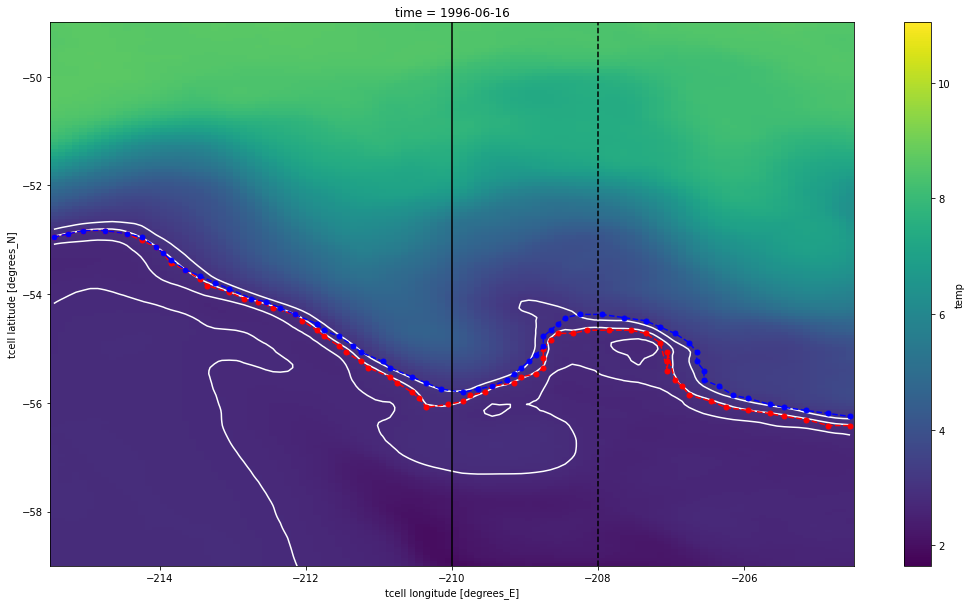

In [16]:
fig, ax = plt.subplots(figsize=(18,10))
ds.temp.plot(ax=ax)
# ds.wt.isel(st_ocean=30).plot(,vmin=-1e-4, vmax=1e-4, cmap=plt.cm.BrBG)
ds.temp.plot.contour(ax=ax, levels=[2.75, 2.9, 3.05], colors='w', linestyles='solid')
ax.plot(along_section_temp.xt_ocean, along_section_temp.yt_ocean, '.--', color='r', markersize=10)
ax.plot(along_section_sl.xt_ocean, along_section_sl.yt_ocean, '.--', color='b', markersize=10)
ax.axvline([-210], color='k', linestyle='solid')
ax.axvline([-208], color='k', linestyle='dashed')

ax.set_ylim([-59, -49])

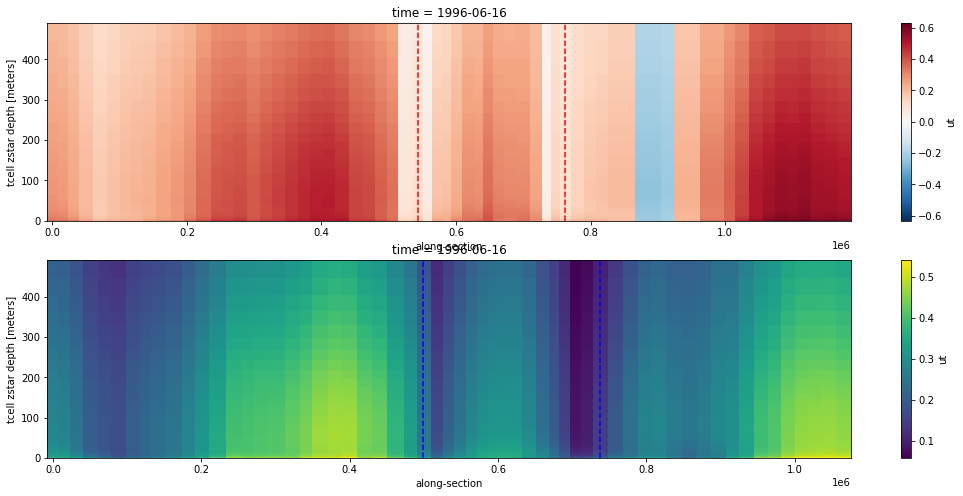

In [17]:
fig, ax = plt.subplots(nrows=2, figsize=(18,8))
along_section_temp.ut.plot(ax=ax[0], x='along-section')
along_section_sl.ut.plot(ax=ax[1], x='along-section')

idx_temp = np.argmin(np.abs(along_section_temp.xt_ocean.values + 210))
idx_sl = np.argmin(np.abs(along_section_sl.xt_ocean.values + 210))

ax[0].axvline(along_section_temp['along-section'][idx_temp], color='r', linestyle='dashed')
ax[1].axvline(along_section_sl['along-section'][idx_sl], color='b', linestyle='dashed')

idx_temp_trough = np.argmin(np.abs(along_section_temp.xt_ocean.values + 208))
idx_sl_trough = np.argmin(np.abs(along_section_sl.xt_ocean.values + 208))

ax[0].axvline(along_section_temp['along-section'][idx_temp_trough], color='r', linestyle='dashed')
ax[1].axvline(along_section_sl['along-section'][idx_sl_trough], color='b', linestyle='dashed')

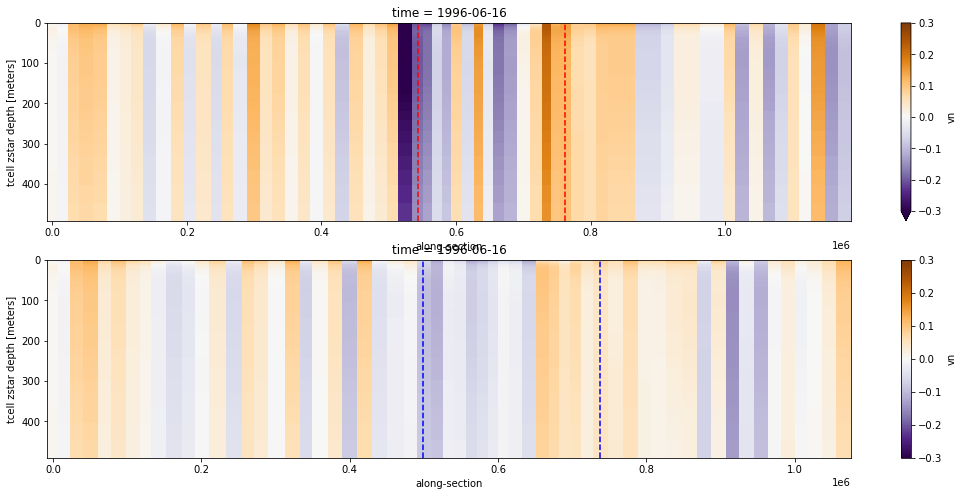

In [24]:
fig, ax = plt.subplots(nrows=2, figsize=(18,8))
along_section_temp.vn.plot(ax=ax[0], x='along-section', cmap=plt.cm.PuOr_r, vmin=-0.3, vmax=0.3)
along_section_sl.vn.plot(ax=ax[1], x='along-section', cmap=plt.cm.PuOr_r, vmin=-0.3, vmax=0.3)

ax[0].axvline(along_section_temp['along-section'][idx_temp], color='r', linestyle='dashed')
ax[1].axvline(along_section_sl['along-section'][idx_sl], color='b', linestyle='dashed')

idx_temp_trough = np.argmin(np.abs(along_section_temp.xt_ocean.values + 208))
idx_sl_trough = np.argmin(np.abs(along_section_sl.xt_ocean.values + 208))

ax[0].axvline(along_section_temp['along-section'][idx_temp_trough], color='r', linestyle='dashed')
ax[1].axvline(along_section_sl['along-section'][idx_sl_trough], color='b', linestyle='dashed')

ax[0].invert_yaxis()
ax[1].invert_yaxis()

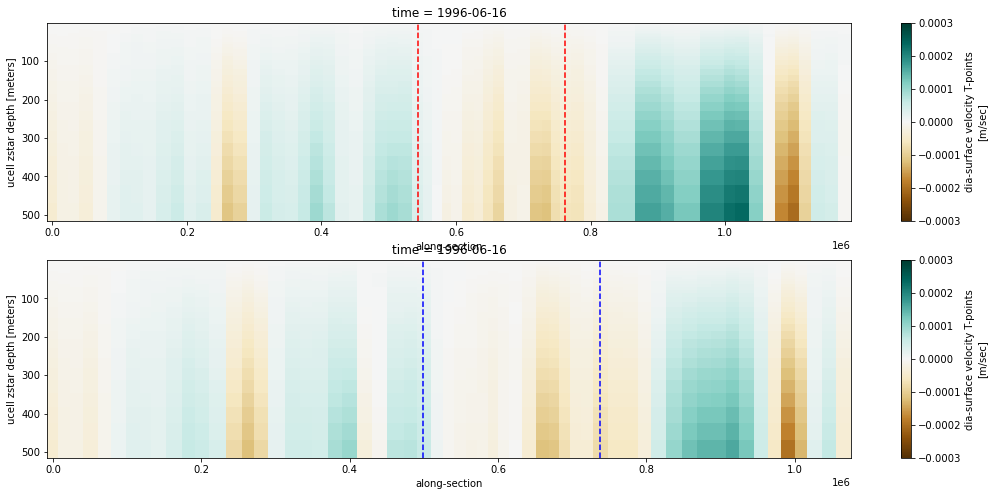

In [25]:
fig, ax = plt.subplots(nrows=2, figsize=(18,8))
along_section_temp.wt.plot(ax=ax[0], x='along-section', cmap=plt.cm.BrBG, vmin=-.3e-3, vmax=.3e-3)
along_section_sl.wt.plot(ax=ax[1], x='along-section', cmap=plt.cm.BrBG, vmin=-.3e-3, vmax=.3e-3)

ax[0].axvline(along_section_temp['along-section'][idx_temp], color='r', linestyle='dashed')
ax[1].axvline(along_section_sl['along-section'][idx_sl], color='b', linestyle='dashed')

idx_temp_trough = np.argmin(np.abs(along_section_temp.xt_ocean.values + 208))
idx_sl_trough = np.argmin(np.abs(along_section_sl.xt_ocean.values + 208))

ax[0].axvline(along_section_temp['along-section'][idx_temp_trough], color='r', linestyle='dashed')
ax[1].axvline(along_section_sl['along-section'][idx_sl_trough], color='b', linestyle='dashed')

ax[0].invert_yaxis()
ax[1].invert_yaxis()